## **1. Data Processing**

### ***1.1 Data Loading***

The *Divine Comedy* is loaded and stored in a variable

In [1]:
with open('divine_comedy.txt', 'r', encoding='ISO-8859-1') as f:
  divine_comedy = f.read()

print(divine_comedy[:231])
print('\n\n[...]\n\n')
print(divine_comedy[-266:])

INFERNO

- Canto I

Nel mezzo del cammin di nostra vita
mi ritrovai per una selva oscura,
ché la diritta via era smarrita.

Ahi quanto a dir qual era è cosa dura
esta selva selvaggia e aspra e forte
che nel pensier rinova la paura!


[...]


ma non eran da ciò le proprie penne:
se non che la mia mente fu percossa
da un fulgore in che sua voglia venne.

A l'alta fantasia qui mancò possa;
ma già volgeva il mio disio e 'l velle,
sì come rota ch'igualmente è mossa,

l'amor che move il sole e l'altre stelle.


### ***1.1 Text Tagging***

We use the provided function `tag` to map the original *Divine Comedy* into a tagged version containing:

* a tag both at the beginning and at the end of each *cantica*

* a tag both at the beginning and at the end of each *canto*

* a tag between each couple of *tercets*

In [2]:
import re

DIVIDING_SYMBOL = '='
MARKERS = {
    'tercet': f'{DIVIDING_SYMBOL}TER{DIVIDING_SYMBOL}',
    'canto start': f'{DIVIDING_SYMBOL}SOC{DIVIDING_SYMBOL}',
    'canto end': f'{DIVIDING_SYMBOL}EOC{DIVIDING_SYMBOL}',
    'cantica start': f'{DIVIDING_SYMBOL}SOCA{DIVIDING_SYMBOL}',
    'cantica end': f'{DIVIDING_SYMBOL}EOCA{DIVIDING_SYMBOL}'
}


def tag(text):
    text = '\n' + text

    # replace canto name with 'end+\n+start' marker
    text = re.sub(
        f'\n- Canto.*\n\n',
        f'{MARKERS["canto end"]}\n{MARKERS["canto start"]}\n',
        text
    )

    # replace previous cantica name + canto end with 'end+\n+start' marker
    for name in ['INFERNO', 'PURGATORIO', 'PARADISO']:
        text = re.sub(
            f'\n{name}\n{MARKERS["canto end"]}',
            f'{MARKERS["canto end"]}\n{MARKERS["cantica end"]}\n{MARKERS["cantica start"]}',
            text
        )

    # bring canto end + cantica end from the beginning to the end
    swap = f'{MARKERS["canto end"]}\n{MARKERS["cantica end"]}'
    text = text[len(swap)+1:] + '\n' + swap

    # replace double space with tercets
    text = re.sub('\n\n', f'\n{MARKERS["tercet"]}\n', text)

    return text


def untag(text):
    for marker in MARKERS.values():
        text = text.replace(marker, '')
    return text

In [3]:
divine_comedy_tagged = tag(divine_comedy)
print(divine_comedy_tagged[:235])
print('\n\n[...]\n\n')
print(divine_comedy_tagged[-295:])

=SOCA=
=SOC=
Nel mezzo del cammin di nostra vita
mi ritrovai per una selva oscura,
ché la diritta via era smarrita.
=TER=
Ahi quanto a dir qual era è cosa dura
esta selva selvaggia e aspra e forte
che nel pensier rinova la paura!
=TER=


[...]


=TER=
ma non eran da ciò le proprie penne:
se non che la mia mente fu percossa
da un fulgore in che sua voglia venne.
=TER=
A l'alta fantasia qui mancò possa;
ma già volgeva il mio disio e 'l velle,
sì come rota ch'igualmente è mossa,
=TER=
l'amor che move il sole e l'altre stelle.
=EOC=
=EOCA=


### ***1.2 Extracting the Verses***

We want to extract verses from the *Divine Comedy* to build a dataset. In particular, we want that the input sequence represents a piece of the *Divine Comedy* going from verse *i* to verse *i+n* and the target sequence represents a piece of the *Divine Comedy* going from verse *i* to verse *i+n+1*

In [4]:
divine_comedy_split = divine_comedy_tagged.split('\n')

for i, verse in enumerate(divine_comedy_split[:20]):
  print(f'{i+1:02} --> {verse}')

01 --> =SOCA=
02 --> =SOC=
03 --> Nel mezzo del cammin di nostra vita
04 --> mi ritrovai per una selva oscura,
05 --> ché la diritta via era smarrita.
06 --> =TER=
07 --> Ahi quanto a dir qual era è cosa dura
08 --> esta selva selvaggia e aspra e forte
09 --> che nel pensier rinova la paura!
10 --> =TER=
11 --> Tant' è amara che poco è più morte;
12 --> ma per trattar del ben ch'i' vi trovai,
13 --> dirò de l'altre cose ch'i' v'ho scorte.
14 --> =TER=
15 --> Io non so ben ridir com' i' v'intrai,
16 --> tant' era pien di sonno a quel punto
17 --> che la verace via abbandonai.
18 --> =TER=
19 --> Ma poi ch'i' fui al piè d'un colle giunto,
20 --> là dove terminava quella valle


In [5]:
print(len(divine_comedy_split))

19150


### ***1.3 Building the Dataset***

The rhyming scheme of the *Divine Comedy* is of the form: `ABA BCB CDC` and so on; thus we will need at least the last 3 verses to predict a correct fourth one, so we set `seq_length = 3`

The total amount of sample is low, since it's not a single-token model, and the dataset is not dense, thus `step_length` of 1 and `train_val_split` of 0.7 are chosen

In [6]:
seq_length = 3
step_length = 1
batch_size = 64
train_val_split = 0.7

tot_samples = int((len(divine_comedy_split) - seq_length) / step_length)
train_samples = round(tot_samples * train_val_split)

print('Train Samples:', train_samples)
print('  Val Samples:', tot_samples - train_samples)

Train Samples: 13403
  Val Samples: 5744


Now, we map the list of verses into a dataset taking 4 verses per time, and splitting them into an input string of the first 3 verses and a target string containing all the 4 verses taken into consideration

In [7]:
from tensorflow.data import Dataset
from tensorflow.strings import reduce_join

def split_input_target(chunk):
  input_text = reduce_join(chunk[:-1], separator='\n') + '\n'
  target_text = reduce_join(chunk, separator='\n') + '\n'
  return input_text, target_text

dataset = Dataset.from_tensor_slices(divine_comedy_split)
dataset = dataset.window(seq_length + 1, step_length, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(seq_length + 1))
dataset = dataset.map(split_input_target).shuffle(tot_samples, seed=0)

Finally, we encode each block of the comedy using the provided `subword_tokenizer` to tokenize the text into subwords, including punctuation. Some special tokens are reserved to the markers

In [8]:
import tensorflow_datasets as tfds
from subword_text_encoder import SubwordTextEncoder

def get_punctuation(text):
    return list(set([char for char in text if char != DIVIDING_SYMBOL and not char.isalnum()]))

def get_words(text):
    text_no_punct = re.sub("[!\"\'\(\),\-\.:;\?]", "", text)
    text_words = [word for word in re.split("[\s\n]", text_no_punct) if word != '']
    return text_words

def subword_tokenizer(text, target_vocab_size=2048, max_subword_length=3):
    # the vocabulary is then made of each different word in the text plus the reserved tokens
    # finally, it gets sorted so that each token index will always be assigned to the same character
    vocabulary = list(set(get_words(text))) + get_punctuation(text)
    vocabulary.sort()
    return SubwordTextEncoder.build_from_corpus(
      corpus_generator=vocabulary,           # generator yielding str, from which subwords will be constructed
      target_vocab_size=target_vocab_size,   # int, approximate size of the vocabulary to create
      max_subword_length=max_subword_length, # int, maximum length of a subword
      reserved_tokens=list(MARKERS.values()) # list<str>, list of tokens that will always be treated as whole tokens and not split up
    )

In [9]:
tokenizer = subword_tokenizer(divine_comedy, target_vocab_size=2048, max_subword_length=3)
print(tokenizer.vocab_size, 'tokens:\n')

for token in tokenizer.subwords[:20]:
  print("'{}'".format('\\n' if token == '\n' else token))

3478 tokens:

'=TER='
'=SOC='
'=EOC='
'=SOCA='
'=EOCA='
'to'
'con'
'ta'
'dis'
'te'
'ti'
'tra'
'chi'
'si'
'se'
'do'
'par'
'ent'
'and'
'pre'


In [10]:
import tensorflow as tf

def encode_dataset(input_dataset, target_dataset):
  def encode_sample(input, target):
    input = [tokenizer.vocab_size] + tokenizer.encode(input.numpy()) + [tokenizer.vocab_size+1]
    target = [tokenizer.vocab_size] + tokenizer.encode(target.numpy()) + [tokenizer.vocab_size+1]
    return input, target

  input_dataset, target_dataset = tf.py_function(encode_sample, [input_dataset, target_dataset], [tf.int64, tf.int64])
  input_dataset.set_shape([None])
  target_dataset.set_shape([None])
  return input_dataset, target_dataset

train_dataset = dataset.take(train_samples).map(encode_dataset)       # Encodes input and target text into a list of integers (IDs)
train_dataset = train_dataset.cache()                                 # Caches the elements in this dataset
train_dataset = train_dataset.padded_batch(batch_size)                # Combines multiple consecutive elements of this dataset into padded batches (a single element)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE) # This allows later elements to be prepared while the current element is being processed, improving latency and throughput

val_dataset = dataset.take(tot_samples - train_samples).map(encode_dataset)
val_dataset = val_dataset.cache()
val_dataset = val_dataset.padded_batch(batch_size)
val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [11]:
for input, target in train_dataset.take(1):
  input = input.numpy()[0]
  target = target.numpy()[0]

  print(f'Input  Shape: {input.shape}')
  print(f'Target Shape: {target.shape}')
  print()

  print('INPUT:\n')
  print(tokenizer.decode([token for token in input if token < tokenizer.vocab_size]))
  print('\n\n---------------------\n\n')
  print('TARGET:\n')
  print(tokenizer.decode([token for token in target if token < tokenizer.vocab_size]))

Input  Shape: (67,)
Target Shape: (73,)

INPUT:

sì che dal dicer mio lo cor non parti".
=TER=
E cominciò questa santa orazione:



---------------------


TARGET:

sì che dal dicer mio lo cor non parti".
=TER=
E cominciò questa santa orazione:
=EOC=



## **2. Model**

### ***2.1 Architecture***

The ***Transformer*** is a state-of-the-art model for *Natural Language Processing* and *Machine Translation* tasks proposed by *Vaswani et al.* in 2017 (https://arxiv.org/pdf/1706.03762v5.pdf)

* It consists of an *Encoder* and a *Decoder*, each of them made up of a given number of layers having two sub-modules: a *Multi-Head Attention* (with a parametric number of heads) sub-module and a classical *Feed-Foward* sub-module

* Also, as it does not use recurrent layers to process strictly sequential data, it both process the input data with a standard token encoding and a *positional encoding* as well

The variable parameters of the model are:
* the number of layers for the *Encoder* and the *Decoder*
* the number of heads for the *Multi-Head Attention* sub-module
* the dimension of all sub-layers in the model, as well as the embedding layers, known as *d_model*
* the inner feed-forward dimension, known as *dff*
* the dropout rate


#### 2.1.1 Positional Encoding

Since this model doesn't contain any recurrence or convolution, positional encoding is added to give the model some information about the relative position of the words in the sentence.

The positional encoding vector is added to the embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of words in a sentence. So after adding the positional encoding, words will be closer to each other based on the similarity of their meaning and their position in the sentence, in the d-dimensional space.

The formula for calculating the positional encoding is as follows:

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

Where *pos* is the position of the current token in its sentence and *i* is the index of the embedding layer (from 0 to *d_model* - 1)

In [12]:
import numpy as np

def positional_encoding(position, d_model):
    def get_angles(pos, i):
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        return pos * angle_rates

    angle_rads = get_angles(np.arange(position)[:, np.newaxis], np.arange(d_model)[np.newaxis, :])
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2]) # apply sin to even indices in the array; 2i
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2]) # apply cos to odd indices in the array; 2i+1
    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

#### 2.1.2 Masking

The padding mask masks all the pad tokens in the batch of sequence. It ensures that the model does not treat padding as the input. The mask indicates where pad value 0 is present: it outputs a 1 at those locations, and a 0 otherwise.

The look-ahead mask is used to mask the future tokens in a sequence. In other words, the mask indicates which entries should not be used.

This means that to predict the third word, only the first and second word will be used. Similarly to predict the fourth word, only the first, second and the third word will be used and so on.

In [13]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]


def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask


def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp) # Encoder padding mask
    dec_padding_mask = create_padding_mask(inp) # Decoder (2nd attention block) padding mask to mask encoder outputs

    # Decoder (1st attention block) mask to pad and mask future tokens in the input received
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

 #### 2.1.3 Scaled Dot Product Attention

The attention function used by the transformer takes three inputs: Q (query), K (key), V (value). The equation used to calculate the attention weights is:

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$



In [14]:
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk) # scale matmul_qk

    if mask is not None:
        scaled_attention_logits += (mask * -1e9) # add the mask to the scaled tensor

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    output = tf.matmul(attention_weights, v)

    return output, attention_weights

#### 2.1.4 Multi-Head Attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">


Multi-head attention consists of four parts:
*    Linear layers and split into heads.
*    Scaled dot-product attention.
*    Concatenation of heads.
*    Final linear layer.

Each multi-head attention block gets three inputs; Q (query), K (key), V (value). These are put through linear (Dense) layers and split up into multiple heads. 

The `scaled_dot_product_attention` defined above is applied to each head (broadcasted for efficiency). The attention output for each head is then concatenated and put through a final `Dense` layer.

In [15]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)

        return output, attention_weights

#### 2.1.5 Point Wise Feed Forward Network

Point wise feed forward network consists of two fully-connected layers with a ReLU activation in between.

In [16]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])

#### 2.1.6 Encoder Layer

Each encoder layer consists of sublayers:

1.   Multi-head attention (with padding mask) 
2.    Point wise feed forward networks. 

Each of these sublayers has a residual connection around it followed by a layer normalization. Residual connections help in avoiding the vanishing gradient problem in deep networks.

The output of each sublayer is `LayerNorm(x + Sublayer(x))`. There are N encoder layers in the transformer.

In [17]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)
        return out2

#### 2.1.7 Decoder Layer

Each decoder layer consists of sublayers:

1.   Masked multi-head attention (with look ahead mask and padding mask)
2.   Multi-head attention (with padding mask). V (value) and K (key) receive the *encoder output* as inputs. Q (query) receives the *output from the masked multi-head attention sublayer.*
3.   Point wise feed forward networks

Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is `LayerNorm(x + Sublayer(x))`. There are N decoder layers in the transformer.

In [18]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)
        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)
        return out3, attn_weights_block1, attn_weights_block2

#### 2.1.8 Encoder

The `Encoder` consists of:
1.   Input Embedding
2.   Positional Encoding
3.   N encoder layers

The input is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.


In [19]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
        return x

#### 2.1.9 Decoder

The `Decoder` consists of:
1.   Output Embedding
2.   Positional Encoding
3.   N decoder layers

The target is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer.

In [20]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)
            attention_weights['decoder_layer{}_block1'.format(i + 1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i + 1)] = block2
        return x, attention_weights

#### 2.1.10 Transformer

Transformer consists of the encoder, decoder and a final linear layer. The output of the decoder is the input to the linear layer and its output is returned.

In [21]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target,
                 rate=0.1):
        super(Transformer, self).__init__()
        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)
        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        final_output = self.final_layer(dec_output)
        return final_output, attention_weights

#### 2.1.11 Learning Rate Scheduler

The learning rate scheduler is set accordingly to the formula in the paper of Vaswani et al. (2017)

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$

In [22]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

#### 2.1.12 Loss and Metrics

The loss used is `SparseCategoricalCrossentropy` and the metric used is `SparseCategoricalAccuracy`. Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.



In [23]:
history = {'train loss': [], 'train acc': [], 'val loss': [], 'val acc': []}

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_) / tf.reduce_sum(mask)

#### 2.1.13 Training and Validation Steps

In [24]:
step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  with tf.GradientTape() as tape:
    predictions, _ = model(inp, tar_inp, True, enc_padding_mask, combined_mask, dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, model.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  
  train_loss(loss)
  train_accuracy(tar_real, predictions)

@tf.function(input_signature=step_signature)
def val_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  with tf.GradientTape() as tape:
    predictions, _ = model(inp, tar_inp, True, enc_padding_mask, combined_mask, dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  val_loss(loss)
  val_accuracy(tar_real, predictions)

#### 2.1.14 Model Summary

In [25]:
from tensorflow.keras.optimizers import Adam

num_layers = 3
num_heads = 4
d_model = 256
dff = 512
dropout = 0.2
input_vocab_size = tokenizer.vocab_size + 2
target_vocab_size = tokenizer.vocab_size + 2
optimizer = Adam(CustomSchedule(d_model), beta_1=0.9, beta_2=0.98, epsilon=1e-9)

model = Transformer(
    num_layers, d_model, num_heads, dff,
    input_vocab_size, target_vocab_size,
    pe_input=input_vocab_size, pe_target=target_vocab_size,
    rate=dropout
)

for (inp, tar) in train_dataset.take(1):
  val_step(inp, tar)

model.summary()

Model: "transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  2472192   
_________________________________________________________________
decoder (Decoder)            multiple                  3263232   
_________________________________________________________________
dense_48 (Dense)             multiple                  894360    
Total params: 6,629,784
Trainable params: 6,629,784
Non-trainable params: 0
_________________________________________________________________


### ***2.2 Training***

In [26]:
import os
import time

epochs = 0

if os.path.isfile('model.h5'):
  model.load_weights('model.h5')
  print('Model restored')
else:
  epochs = 70
  batches_interval = 20

  for epoch in range(epochs):
    start = time.time()
    train_loss.reset_states()
    train_accuracy.reset_states()
    val_loss.reset_states()
    val_accuracy.reset_states()
    print(f'Starting Epoch {epoch+1}/{epochs}')
    
    for (batch, (inp, tar)) in enumerate(train_dataset):
      train_step(inp, tar)
      if (batch + 1) % batches_interval == 0:
        print(f'  > Batch {batch+1}', end=' \t\t ')
        print(f'- train_loss: {train_loss.result():.4f} - train_acc: {train_accuracy.result():.4f}')      
    history['train loss'].append(train_loss.result())
    history['train acc'].append(train_accuracy.result())

    for (batch, (inp, tar)) in enumerate(val_dataset):
      val_step(inp, tar)  
    history['val loss'].append(val_loss.result())
    history['val acc'].append(val_accuracy.result())

    elapsed = time.time() - start
    print(f'Ending Epoch {epoch+1}/{epochs}', end=' \t ')
    print(f'- train_loss: {history["train loss"][-1]:.4f} - train_acc: {history["train acc"][-1]:.4f}', end=' ')
    print(f'- val_loss: {history["val loss"][-1]:.4f} - val_acc: {history["val acc"][-1]:.4f}')
    print(f'Elapsed Time {elapsed:.2f}s\n')

Model restored


Here's a graphical representation of the improvement of the model, with respect both to the loss and the accuracy, across the epochs

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
sns.set_context('notebook')

if epochs > 0:
  plt.figure(figsize=(12, 5))

  plt.subplot(1, 2, 1)
  plt.plot(np.arange(epochs) + 1, history['train loss'], label='train')
  plt.plot(np.arange(epochs) + 1, history['val loss'], label='val')
  plt.legend()
  plt.title('Loss')

  plt.subplot(1, 2, 2)
  plt.plot(np.arange(epochs) + 1, history['train acc'], label='train')
  plt.plot(np.arange(epochs) + 1, history['val acc'], label='val')
  plt.legend()
  plt.title('Accuracy')

  plt.show()

## **3. Results**

Here, at first, we will use the model to predict some verses and show the respective attention plots to understand how the model is behaving, then, we will proceed with the generation of a full canto, which uses a `temperature_factor` to allow some degree of randomness

> The next token is chosen among a subset of those having a probability which is at least `1 / temperature_factor` with respect to the maximal one

> It goes without saying that a higher `temperature_factor` leads to a more explorative generation, while a lower `temperature_factor` leads to a more conservative one (in particular, with `temperature_factor = 1` the generation is completely deterministic)

### ***3.1 Evaluation***



In [28]:
from tensorflow.nn import softmax

newline_token = tokenizer.encode('\n')[0]

# produce output verses starting from a given input list of verses
def evaluate(inp_list, max_length=35, temperature_factor=1, verbose=False):
  # the input is the tokenized string obtained from the given input list
  input = tokenizer.encode('\n'.join(inp_list))

  # the encoder input is surrounded by a start and an end token
  encoder_input = tf.expand_dims([tokenizer.vocab_size] + input + [tokenizer.vocab_size + 1], 0)

  # the decoder input is the same sentence preceded by a start token
  decoder_input = tf.expand_dims([tokenizer.vocab_size] + input, 0)

  # the final output of the evaluation (initially, this is an empty list)
  output = []

  # we repeat the process to get the entire verse (until the end token or the newline token is predicted)
  for i in range(max_length):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, decoder_input)  
    logits, attention_weights = model(
        encoder_input, decoder_input, False,
        enc_padding_mask, combined_mask, dec_padding_mask
    )

    # we get the probabilities for the decoded token (the last one)
    probabilities = softmax(logits[0, -1, :tokenizer.vocab_size]).numpy()

    # we take a subset of possible tokens whose probability is at least 1/temperature_factor of the maximal one
    indices = np.arange(tokenizer.vocab_size)[probabilities >= probabilities.max() / temperature_factor]

    # we renormalize this subset using, again, a softmax activation
    probabilities = softmax(probabilities[probabilities >= probabilities.max() / temperature_factor]).numpy()
    
    # the id is randomly chosen among the indices according to the computed probabilities
    predicted_id = np.random.choice(indices, size=1, p=probabilities)[0]
    
    # if the token coincides with the nd token or the newline token, the generation is interrupted
    if predicted_id == newline_token or predicted_id >= tokenizer.vocab_size:
      break

    # otherwise the token is appended both to the new decoder input and to the final output
    decoder_input = tf.concat([decoder_input, [[predicted_id]]], axis=-1)
    output.append(predicted_id)

    if verbose:
      print(tokenizer.decode([predicted_id]), end='')

  return output, attention_weights

In [29]:
def plot_attention_weights(attention, sentence, result, layer):
  fig = plt.figure(figsize=(25, 25))  
  sentence = tokenizer.encode(sentence)
  attention = tf.squeeze(attention[layer], axis=0)
  
  for head in range(attention.shape[0]):
    ax = fig.add_subplot(attention.shape[0], 1, head+1)
    ax.matshow(attention[head][:-1, :], cmap='gray')
    fontdict = {'fontsize': 18}    
    ax.set_xticks(range(len(sentence)+2))
    ax.set_yticks(range(len(result)))    
    ax.set_ylim(len(result)-1.5, -0.5)
    ax.set_xticklabels(['<start>'] + [tokenizer.decode([i]) for i in sentence] + ['<end>'], fontdict=fontdict, rotation=90)
    ax.set_yticklabels([tokenizer.decode([i]) for i in result if 0 < i < tokenizer.vocab_size], fontdict=fontdict)
    ax.set_xlabel('Head {}'.format(head+1))
  
  plt.tight_layout()
  plt.show()

INPUT:
=TER=
Tant' è amara che poco è più morte;
ma per trattar del ben ch'i' vi trovai,


TARGET:
dirò de l'altre cose ch'i' v'ho scorte.



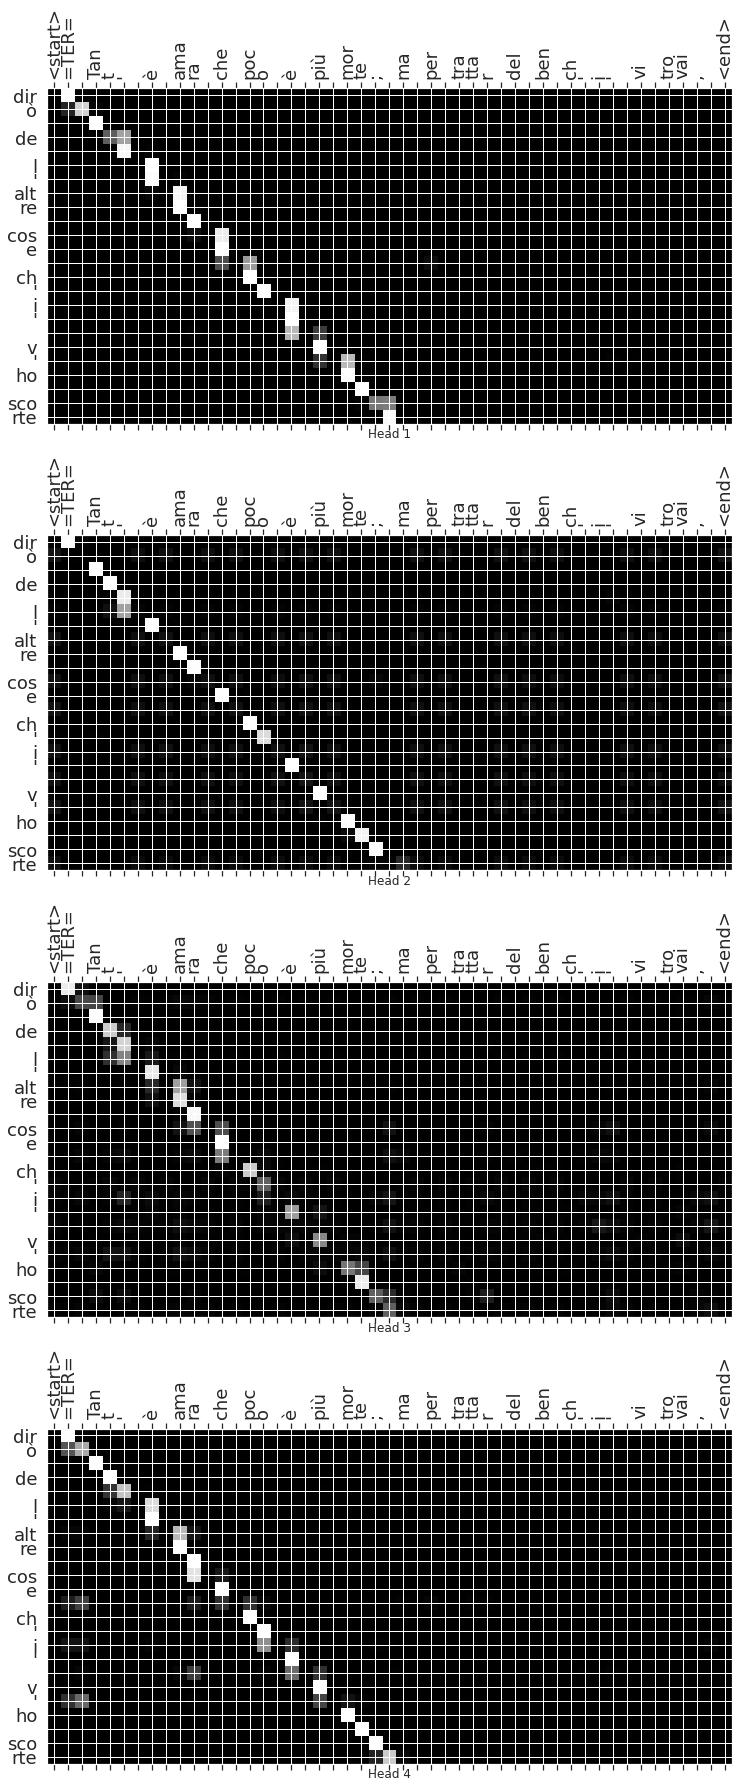

In [30]:
i = 9
sentence_list = divine_comedy_split[i:i+seq_length] + ['']

sentence = '\n'.join(sentence_list)
target, attention_weights = evaluate(sentence_list)

print('INPUT:')
print(sentence)
print()
print('TARGET:')
print(tokenizer.decode([t for t in target if 0 < t < tokenizer.vocab_size]))
print()
plot_attention_weights(attention_weights, sentence, target, 'decoder_layer3_block2')

### ***3.2 Generation***

In [31]:
def generate(
    input_string=divine_comedy_tagged[:386], # first three tercets of the comedy
    max_iterations=250, end_marker=MARKERS['canto end'],
    temperature_factor=1.0, verbose=False
):
  # at the beginning, the generated string is the encoding of the input string (plus a newline character)
  generated_string = input_string

  for i in range(max_iterations):
    # the input list is made up of the last 'seq_length' verses (-1 for the last blank verse to be filled)
    input_list = generated_string.split('\n')[-seq_length-1:]

    # the generated verse is then decoded
    target, _ = evaluate(input_list, temperature_factor=temperature_factor, verbose=verbose)
    generated_verse = tokenizer.decode(target)
    if verbose:
      print()

    # if the verse coincides with the end marker, the generation is interrupted, otherwise it is appended with a newline
    if generated_verse == end_marker:
      break
    generated_string += generated_verse + '\n'
  
  # we finally return the decoded (and untagged) string, excluding the input provided by the user
  return untag(generated_string[len(input_string):])

In [32]:
generated_canto = generate(temperature_factor=1.0, verbose=True)

per me' chii' chini,
ma 'l tuo sommo bene è tanto,
si disse: "Maestro, or mi puoi il mio paterno;
=TER=
e cerchio il suggel cor santo stretto
de la virtù che fa conviene al segno,
e al tratto mio ben l'innocenti al petto.
=TER=
In quel che piace a me l'hanno in ira
fosse in quel che ci ha fatto in ira,
secondo che Dio convien che più spira.
=TER=
Se venir sù l'allor vi disira",
disse 'l maestro mio sanza parte accende,
"quel bene ha mestier di là si tira".
=TER=
E io l'accorgor; né lo ritene,
ho io d'i pianeti che far l'esser legge,
né ferma qui pena che non m'accende.
=TER=
E 'l savio come me stesse cade
de la mente lor di quei che 'l ciel chiaro
tutte quante a la quattro strade.
=TER=
Con più oltre era ancor non sanza giuro,
così per esser lor passaver remi
poscia che nel viso suo ver giuro.
=TER=
Ma quel digiunto, del nostro mondo
sen va in dietro, e 'l viso girone
del tuo maestro e io disir mi secondo;
=TER=
e quel che più lieve si può fare,
s'io non era ancor di là dal volto,
come

In [33]:
from metrics.metrics import evaluate

evaluate(generated_canto, divine_comedy)

{'Hendecasyllabicness': 0.9049486803519059,
 'Plagiarism': 0.9585879158180584,
 'Putative Tercets': 62,
 'Repetitivity': 0.9979633401221996,
 'Rhymeness': 0.8961748633879781,
 'Text Structuredness': 0.9960159362549801,
 'Well-Formed Tercets': 62}

In [34]:
print(generated_canto)

per me' chii' chini,
ma 'l tuo sommo bene è tanto,
si disse: "Maestro, or mi puoi il mio paterno;

e cerchio il suggel cor santo stretto
de la virtù che fa conviene al segno,
e al tratto mio ben l'innocenti al petto.

In quel che piace a me l'hanno in ira
fosse in quel che ci ha fatto in ira,
secondo che Dio convien che più spira.

Se venir sù l'allor vi disira",
disse 'l maestro mio sanza parte accende,
"quel bene ha mestier di là si tira".

E io l'accorgor; né lo ritene,
ho io d'i pianeti che far l'esser legge,
né ferma qui pena che non m'accende.

E 'l savio come me stesse cade
de la mente lor di quei che 'l ciel chiaro
tutte quante a la quattro strade.

Con più oltre era ancor non sanza giuro,
così per esser lor passaver remi
poscia che nel viso suo ver giuro.

Ma quel digiunto, del nostro mondo
sen va in dietro, e 'l viso girone
del tuo maestro e io disir mi secondo;

e quel che più lieve si può fare,
s'io non era ancor di là dal volto,
come fa di noi per la grazia non si chiude.
